# CS145 Howework 3, Part 1: kNN

<span style="color:red"> **Important Note:** </span>
HW3 is due on **11:59 PM PT, May 15 (Monday)**. Please submit through GradeScope.

Note that Howework #3 includes two jupyter notebooks (Part 1: kNN and Part 2: Neural Network), please merge the reports into one pdf in your submission.

----

## Print Out Your Name and UID

<span style="color:blue"> **Name: Warren Pagsuguiron, UID: 205314301** </span>

----

## Before You Start

You need to first create HW3 conda environment specified in `cs145hw3.yml` file. If you have `conda` properly installed, you may create, activate or deactivate the env with the following commands:

```
conda env create -f cs145hw3.yml
conda activate hw3
conda deactivate
```
OR

```
conda env create --name NAMEOFYOURCHOICE -f cs145hw3.yml 
conda activate NAMEOFYOURCHOICE
conda deactivate
```
To view the list of your environments, use the following command:
```
conda env list
```

References can be found [here](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html).

You must not delete any code cells in this notebook. If you change any code outside the blocks (such as hyperparameters) that you are allowed to edit (between `STRART/END YOUR CODE HERE`), you need to highlight these changes. You may add some additional cells to help explain your results and observations.

## Download and prepare the dataset

Download the CIFAR-10 dataset (file size: ~163M) [here](http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz). Unzip and place the folder under `hw3/data/datasets/`.

After downloading the dataset, you can start your notebook from the HW3 directory. Note that the dataset is used in both jupyter notebooks (kNN and Neural Networks). You only need to download the dataset once.

## Import the appropriate libraries

In [2]:
import numpy as np # for doing most of our calculations
import matplotlib.pyplot as plt# for plotting
from data.data_utils import load_CIFAR10 # function to load the CIFAR-10 dataset.

# Load matplotlib images inline
%matplotlib inline

# These are important for reloading any code you write in external .py files.
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Now, to verify that the dataset has been successfully installed, use the following code to print out the shape of train/test data and labels. The output shapes for train/test data should be (50000, 32, 32, 3) and (10000, 32, 32, 3), and the label size should be (50000,) and (10000,).

In [3]:
# Set the path to the CIFAR-10 data
cifar10_dir = './data/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


Visualize some examples from the dataset.

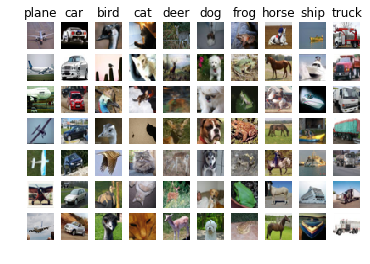

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Subsample the data to speedup the experiments
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


## Implement K-nearest neighbors algorithms

In the following cells, you will build a KNN classifier and choose hyperparameters via k-fold cross-validation.

In [6]:
# Import the KNN class
from hw3code import KNN

In [30]:
# Declare an instance of the knn class.
knn = KNN()

# Train the classifier.
#   We have implemented the training of the KNN classifier.
#   Look at the train function in the KNN class to see what this does.
knn.train(X=X_train, y=y_train)

**Questions**

(1) Describe what is going on in the function knn.train().

(2) What are the pros and cons of this training step of KNN?

**Answers**

1. We are simply giving the model the dataset and labels in the train function. The "heavy lifting", the using of the data and labels will be donw when classifying.

2. 

Pros: Easy training, fast training, easy to understand, doesn't really require a training phase

Cons: Slow classfication and computationally expensive, have to carry entire data-set when classifying

---

## KNN prediction

In the following sections, you will implement the functions to calculate the distances of test points to training points, and from this information, predict the class of the KNN. \
**Hint: If you implemented this correctly, evaluating np.linalg.norm(dists_L2, 'fro') should return: ~7906696**

In [31]:
# Implement the function compute_distances() in the KNN class.
# Do not worry about the input 'norm' for now; use the default definition of the norm
#   in the code, which is the 2-norm.
# You should only have to fill out the clearly marked sections.

import time
time_start =time.time()

dists_L2 = knn.compute_distances(X=X_test)

print('Time to run code: {}'.format(time.time()-time_start))
print('Frobenius norm of L2 distances: {}'.format(np.linalg.norm(dists_L2, 'fro')))

Time to run code: 19.319287061691284
Frobenius norm of L2 distances: 7906696.077040902


### Really slow?

The above code probably takes a while to finish. This is because we are using iterative implementation (two for loops).  We could optimize the implementation with vectorization, i.e. by removing the for loops.

### KNN vectorization

The above code took far too long to run.  If we wanted to optimize hyperparameters, it would be time-expensive.  Thus, we will speed up the code by vectorizing it, removing the for loops.

In [37]:
# Implement the function compute_L2_distances_vectorized() in the KNN class.
# In this function, you ought to achieve the same L2 distance but WITHOUT any for loops.
# Note, this is SPECIFIC for the L2 norm.

time_start =time.time()
dists_L2_vectorized = knn.compute_L2_distances_vectorized(X=X_test)
print('Time to run code: {}'.format(time.time()-time_start))
print('Difference in L2 distances between your KNN implementations (should be 0): {}'.format(np.linalg.norm(dists_L2 - dists_L2_vectorized, 'fro')))

Time to run code: 1.1098899841308594
Difference in L2 distances between your KNN implementations (should be 0): 0.0


### Speedup

You should see a 20-100x speed up from vectorization and no difference in L2 distances between two implementations. 

On our computer, the vectorized form took 0.20 seconds while the naive implementation took 26.88 seconds. 

## Implementing KNN prediction

Now that we have functions to calculate the distances from a test point to given training points, we can implement the function that predicts the test point labels. If you implemented this correctly, the error should be around 0.71. This means that the k-nearest neighbors classifier is right only around 29% of the time, which is not great.

In [28]:
# Implement the function predict_labels in the KNN class.
# Calculate the training error (num_incorrect / total_samples) 
#   from running knn.predict_labels with k=10

error = 1

# ================================================================ #
# START YOUR CODE HERE
# ================================================================ #
#   Calculate the error rate by calling predict_labels on the test 
#   data with k = 10.  Store the error rate in the variable error.
# ================================================================ #
pred = knn.predict_labels(dists_L2, 3)
num_incorrect = 0
for y_hat, y_ground in zip(pred, y_test):
    if y_hat != y_ground:
        num_incorrect += 1
        
error = num_incorrect / len(y_test)
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #

print(error)

0.728


---

## End of Homework 3, Part 1

After you've finished both parts the homework, please print out the both of the entire `ipynb` notebooks and `py` files into one PDF file. Make sure you include the output of code cells and answers for questions. Prepare submit it to GradeScope. Do not include any dataset in your submission.  